# Laboratorium MSI 5 - SSN Rynek Dnia Następnego - predykcja szeregów czasowych

Imię i nazwisko: Paweł Okapiec

### Zbiór danych

Celem jest predykcja ceny energii elektrycznej na polskim Rynku Dnia Następnego (kontrakty zawierane na kolejny dzień) na 24h do przodu

* fixing  - szukana cena [zł/MWh]
* fixing_1_volume - obrót w danej godzinie [MWh]
* hour - godzina
* date - data

Pozostałe wg danych PSE https://www.pse.pl/dane-systemowe/plany-pracy-kse/biezacy-plan-koordynacyjny-dobowy-bpkd/wielkosci-podstawowe
* JWCD - jednostki wytwórcze centralnie dysponowane
* nJWCD - pozostałe (w tym np energia wiatrowa)

In [ ]:
import pandas as pd # biblioteka do działań na danych w postaci tabelarycznej
import matplotlib.pyplot as plt
import seaborn as sns # druga biblioteka do wykresów
import tensorflow as tf

### Wczytujemy i wyświetlamy zbiór danych

In [ ]:
df = pd.read_csv('rdn_data_lab5.csv', sep=';')
df

,fixing,fixing_1_volume,hour,date,Krajowe zapotrzebowanie na moc,Suma zdolności wytwórczych JWCD,Suma zdolności wytwórczych nJWCD,Generacja JWCD,Generacja nJWCD,Generacja źródeł wiatrowych,Wymagana rezerwa mocy ponad zapotrzebowanie
0,70.50,2582.7,0,2017-12-25,14250,22290,11171,4067,10183,5053,1285
1,70.03,2672.5,1,2017-12-25,13450,22290,11087,3353,10097,4972,1213
2,70.03,2439.4,2,2017-12-25,12913,22290,10963,2945,9968,4852,1164
3,70.03,2370.0,3,2017-12-25,12575,22290,10846,2724,9851,4736,1134
4,70.03,2378.7,4,2017-12-25,12475,22290,10687,2785,9690,4582,1125
...,...,...,...,...,...,...,...,...,...,...,...
11422,190.49,3016.6,22,2019-04-14,17425,21284,7938,10330,7095,2191,1563
11423,172.40,2843.3,23,2019-04-14,16300,21284,7775,9363,6937,2035,1462
11424,195.26,2673.0,0,2019-04-15,15188,21743,7562,8412,6776,1809,1362
11425,196.82,2790.9,1,2019-04-15,14675,21803,7382,8080,6595,1660,1315


In [ ]:
# formatowanie dat (to nie ważne, potrzebne do opisu osi na wykresie)
df['date_hour'] = df['date'] + ' ' + df['hour'].astype(str).str.pad(width=2, fillchar='0')
df['date_hour'] = pd.to_datetime(df['date_hour'], format="%Y-%m-%d %H")
df.set_index('date_hour', inplace=True)

### Silna zależność od godziny i dnia tygodnia

In [ ]:
# mozliwość przesuwania i powiększania wykresu
# %matplotlib notebook # nie działa w google colab :()
# uwaga: po zakończeniu oglądania lepiej zamknąć

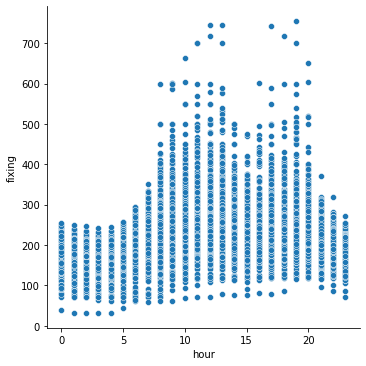

In [ ]:
sns.relplot(data=df, x='hour', y='fixing')

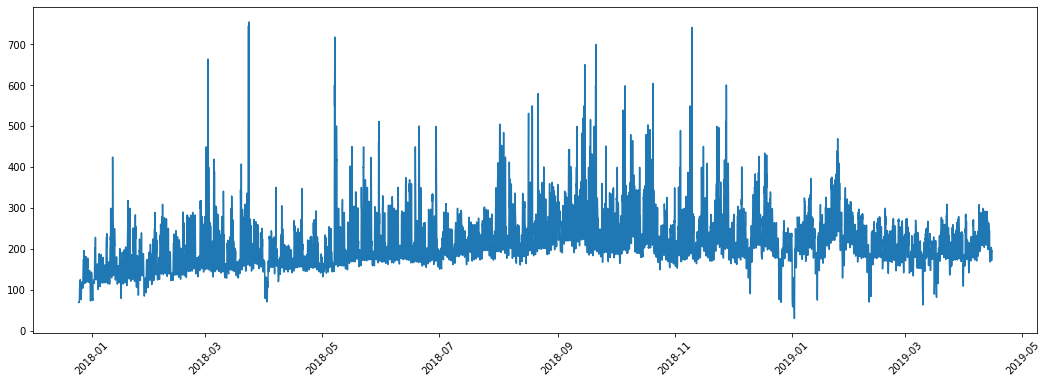

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(df['fixing'])
plt.xticks(rotation=45);
plt.show()

### Opóźnienie danych wyjściowych

In [ ]:
df['fixing_minus_24h'] = df['fixing'].shift(24)

In [ ]:
df

,fixing,fixing_1_volume,hour,date,Krajowe zapotrzebowanie na moc,Suma zdolności wytwórczych JWCD,Suma zdolności wytwórczych nJWCD,Generacja JWCD,Generacja nJWCD,Generacja źródeł wiatrowych,Wymagana rezerwa mocy ponad zapotrzebowanie,fixing_minus_24h
date_hour,,,,,,,,,,,,
2017-12-25 00:00:00,70.50,2582.7,0,2017-12-25,14250,22290,11171,4067,10183,5053,1285,NaN
2017-12-25 01:00:00,70.03,2672.5,1,2017-12-25,13450,22290,11087,3353,10097,4972,1213,NaN
2017-12-25 02:00:00,70.03,2439.4,2,2017-12-25,12913,22290,10963,2945,9968,4852,1164,NaN
2017-12-25 03:00:00,70.03,2370.0,3,2017-12-25,12575,22290,10846,2724,9851,4736,1134,NaN
2017-12-25 04:00:00,70.03,2378.7,4,2017-12-25,12475,22290,10687,2785,9690,4582,1125,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-14 22:00:00,190.49,3016.6,22,2019-04-14,17425,21284,7938,10330,7095,2191,1563,200.69
2019-04-14 23:00:00,172.40,2843.3,23,2019-04-14,16300,21284,7775,9363,6937,2035,1462,199.52
2019-04-15 00:00:00,195.26,2673.0,0,2019-04-15,15188,21743,7562,8412,6776,1809,1362,181.98


In [ ]:
df['fixing_minus_7d'] = df['fixing'].shift(24 * 7)

In [ ]:
df

,fixing,fixing_1_volume,hour,date,Krajowe zapotrzebowanie na moc,Suma zdolności wytwórczych JWCD,Suma zdolności wytwórczych nJWCD,Generacja JWCD,Generacja nJWCD,Generacja źródeł wiatrowych,Wymagana rezerwa mocy ponad zapotrzebowanie,fixing_minus_24h,fixing_minus_7d
date_hour,,,,,,,,,,,,,
2017-12-25 00:00:00,70.50,2582.7,0,2017-12-25,14250,22290,11171,4067,10183,5053,1285,NaN,NaN
2017-12-25 01:00:00,70.03,2672.5,1,2017-12-25,13450,22290,11087,3353,10097,4972,1213,NaN,NaN
2017-12-25 02:00:00,70.03,2439.4,2,2017-12-25,12913,22290,10963,2945,9968,4852,1164,NaN,NaN
2017-12-25 03:00:00,70.03,2370.0,3,2017-12-25,12575,22290,10846,2724,9851,4736,1134,NaN,NaN
2017-12-25 04:00:00,70.03,2378.7,4,2017-12-25,12475,22290,10687,2785,9690,4582,1125,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-14 22:00:00,190.49,3016.6,22,2019-04-14,17425,21284,7938,10330,7095,2191,1563,200.69,190.39
2019-04-14 23:00:00,172.40,2843.3,23,2019-04-14,16300,21284,7775,9363,6937,2035,1462,199.52,183.23
2019-04-15 00:00:00,195.26,2673.0,0,2019-04-15,15188,21743,7562,8412,6776,1809,1362,181.98,191.10


In [ ]:
# TODO - dodatkowe kolumny z opóźnieniami (można dodać, nie są konieczne)
df['fixing_minus_48h'] = df['fixing'].shift(24 * 2)

In [ ]:
# usunięcie braków danych spowodowanych przesuwaniem
df.dropna(inplace=True)

In [ ]:
df

,fixing,fixing_1_volume,hour,date,Krajowe zapotrzebowanie na moc,Suma zdolności wytwórczych JWCD,Suma zdolności wytwórczych nJWCD,Generacja JWCD,Generacja nJWCD,Generacja źródeł wiatrowych,Wymagana rezerwa mocy ponad zapotrzebowanie,fixing_minus_24h,fixing_minus_7d,fixing_minus_48h
date_hour,,,,,,,,,,,,,,
2018-01-01 00:00:00,117.00,2140.9,0,2018-01-01,15175,22312,9327,6835,8340,3157,1368,98.00,70.50,121.03
2018-01-01 01:00:00,113.59,2255.8,1,2018-01-01,14600,22312,9272,6315,8285,3107,1316,82.00,70.03,121.03
2018-01-01 02:00:00,97.00,2516.5,2,2018-01-01,14025,22312,9263,5749,8276,3103,1264,76.14,70.03,121.03
2018-01-01 03:00:00,89.00,2512.1,3,2018-01-01,13625,22312,9296,5316,8309,3136,1228,74.70,70.03,121.03
2018-01-01 04:00:00,75.00,2512.4,4,2018-01-01,13400,22312,9402,4985,8415,3242,1208,73.78,70.03,121.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-14 22:00:00,190.49,3016.6,22,2019-04-14,17425,21284,7938,10330,7095,2191,1563,200.69,190.39,235.00
2019-04-14 23:00:00,172.40,2843.3,23,2019-04-14,16300,21284,7775,9363,6937,2035,1462,199.52,183.23,220.00
2019-04-15 00:00:00,195.26,2673.0,0,2019-04-15,15188,21743,7562,8412,6776,1809,1362,181.98,191.10,199.52


### Podział na zbiór uczący i testowy

In [ ]:
df_train = df[df.index < '01-01-2019'] 
df_test = df[df.index >= '01-01-2019'] 
print(len(df_train))
print(len(df_test))

8760
2499


In [ ]:
# lista kolumn, które będą danymi wejściowymi - proszę poeksperymentować z różnymi wejściami i różnymi opóźnieniami
cols = ['fixing_minus_24h', 'fixing_minus_7d', 'Generacja JWCD']
# TODO modyfikacja listy zmiennych wejściowych

In [ ]:
y_train = df_train['fixing']
X_train = df_train[cols]
y_test = df_test['fixing']
X_test = df_test[cols]


### Sieć neuronowa

https://keras.io/

* żeby minimalizować błąd średniokwadratowy stosujemy loss='mean_squared_error'
* kwadrat błędu ciężko zinterpretować, więc jako metrics (wyświetlane wyniki, jak accuracy) można wykorzystać pierwiastek z błędu średniokwadratowego tf.keras.metrics.RootMeanSquaredError() lub/oraz średni błąd bezwzględny 'mean_absolute_error'

In [ ]:
model = tf.keras.Sequential()
# TODO tworzenie sieci tutaj
# przykład tworzenia sieci MLP w plikach z wykładu: keras_mlp_na wyklad.ipnyb - proszę zwrócić uwagę, że tu mamy problem regresji
# co oznacza, że należy zastosować liniową funkcję aktywacji neuronu wyjściowego
# i funkcję kosztu w postaci np błędu średniokwadratowego
model.add(tf.keras.layers.Dense(32, input_shape=(3,)))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics = [tf.keras.metrics.RootMeanSquaredError()])
#history = model.fit(X_test, y_test, epochs=100)

In [ ]:
# epochs - liczba przejść przez cały zbiór uczący - proszę spróbować też innych wartości
model.fit(X_train, y_train, epochs=500)

Epoch 1/500
274/274 [==============================] - 0s 1ms/step - loss: 12654.8652 - root_mean_squared_error: 112.4938
Epoch 2/500
274/274 [==============================] - 0s 1ms/step - loss: 2407.0154 - root_mean_squared_error: 49.0613
Epoch 3/500
274/274 [==============================] - 0s 1ms/step - loss: 2721.2917 - root_mean_squared_error: 52.1660
Epoch 4/500
274/274 [==============================] - 0s 1ms/step - loss: 2368.9963 - root_mean_squared_error: 48.6723
Epoch 5/500
274/274 [==============================] - 0s 1ms/step - loss: 3113.2209 - root_mean_squared_error: 55.7962
Epoch 6/500
274/274 [==============================] - 0s 1ms/step - loss: 2280.2549 - root_mean_squared_error: 47.7520
Epoch 7/500
274/274 [==============================] - 0s 1ms/step - loss: 2384.2854 - root_mean_squared_error: 48.8291
Epoch 8/500
274/274 [==============================] - 0s 1ms/step - loss: 2155.5271 - root_mean_squared_error: 46.4277
Epoch 9/500
274/274 [=================

In [ ]:
model.evaluate(X_train, y_train)

274/274 [==============================] - 0s 886us/step - loss: 1606.2708 - root_mean_squared_error: 40.0783


[1606.270751953125, 40.07830810546875]

In [ ]:
model.evaluate(X_test, y_test)

79/79 [==============================] - 0s 1ms/step - loss: 572.0389 - root_mean_squared_error: 23.9173


[572.0389404296875, 23.917335510253906]

In [ ]:
y_hat = model.predict(X_test)
y_hat

array([[126.403435],
       [111.58722 ],
       [ 96.74836 ],
       ...,
       [150.61603 ],
       [145.89215 ],
       [143.60529 ]], dtype=float32)

### Wykres przewidzianych i prawdziwych wartości

In [ ]:
#plt.plot(history.history['loss'])


In [ ]:
df_plot = pd.DataFrame(y_test)
df_plot['y_hat'] = y_hat

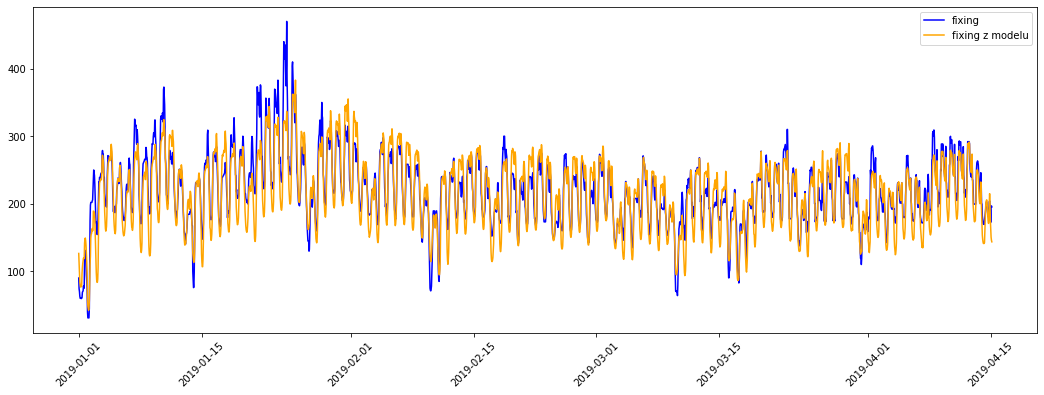

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(df_plot['fixing'], 'blue')
plt.plot(df_plot['y_hat'], 'orange')
plt.xticks(rotation=45);
plt.legend(['fixing', 'fixing z modelu'])

### Wnioski

Proszę tu o krótki komentarz odnośnie uzyskanych wyników i testowanych modeli

*   Dodanie kolejnych warstw ukrytych zmniejsza koszt oraz wartość błędu (do pewnego momentu , potem wynik jest lepszy jednak wprowadzane są tylko niepotrzebne obciązenia dużą ilością obliczeń)
*   Ilość iteracji polepsza wynik zarówno kosztu(zmniejsza go) jak i pierwiastek błędu średniokwadratowego
*   Dodając kolejny argument do wejścia czasem wynik był lepszy a czasme gorszy jednak w znacznej większości sytuacji mniejsza wartość kolumn na wejściu dawała lepsze rezultaty
*   Dodając kolejną kolumne opuźniającą dostajemy gorsze wyniki
*   Zwiększenie liczby neuronów polepsza wyniki zmniejszając koszt oraz wartość błędu (do pewnego momentu, przekraczając pewną wartość wyniki mogą się pogorszyć albo być takie same i obciązyć niepotrzebnie jednostkę obliczeniową)



